In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import pickle
import pandas as pd
#from inference_weather import download_weather_for_inference
from output_utils import plot_heatmap_on_map, extract_year_month
#from inference_ndvi import download_ndvi_for_inference
import geopandas
import matplotlib.pyplot as plt
import xgboost as xgb
import hopsworks
from dateutil.relativedelta import relativedelta

In [30]:
project = hopsworks.login()
fs = project.get_feature_store() 
mr = project.get_model_registry()

2026-01-05 16:09:05,911 INFO: Closing external client and cleaning up certificates.
2026-01-05 16:09:05,913 INFO: Connection closed.
2026-01-05 16:09:05,914 INFO: Initializing external client
2026-01-05 16:09:05,915 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 16:09:05,913 INFO: Connection closed.
2026-01-05 16:09:05,914 INFO: Initializing external client
2026-01-05 16:09:05,915 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-05 16:09:05,911 INFO: Closing external client and cleaning up certificates.
2026-01-05 16:09:05,913 INFO: Connection closed.
2026-01-05 16:09:05,914 INFO: Initializing external client
2026-01-05 16:09:05,915 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 16:09:05,913 INFO: Connection closed.
2026-01-05 16:09:05,914 INFO: Initializing external client
2026-01-05 16:09:05,915 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-05 16:09:05,911 INFO: Closing external client and cleaning up certificates.
2026-01-05 16:09:05,913 INFO: Connection closed.
2026-01-05 16:09:05,914 INFO: Initializing external client
2026-01-05 16:09:05,915 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 16:09:05,913 INFO: Connection closed.
2026-01-05 16:09:05,914 INFO: Initializing external client
2026-01-05 16:09:05,915 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-05 16:09:07,227 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286351

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286351


# Download data features from Hopsworks

In [31]:
weather_fg = fs.get_feature_group(name='weather', version=1)
#ndvi_fg = fs.get_feature_group(name='ndvi', version=1)


In [32]:
weather_fg.read()

2026-01-05 16:09:39,324 ERROR: Binder Error: Referenced column "{'name': 'lat', 'type': 'double'}" not found in FROM clause!
Candidate bindings: "read_parquet.lat"
LINE 1: ... table "ebbalg99.weather_2" as (select "{'name': 'lat', 'type': 'double'}", "{...
                                                  ^. Detail: Python exception: Traceback (most recent call last):
  File "/usr/src/app/src/server.py", line 142, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 166, in wrapper
    result = func(instance, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 196, in do_get
    return self._read_query(context, path, command)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 123, in wrapper
    return func(instance, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 131, i

2026-01-05 16:09:39,324 ERROR: Binder Error: Referenced column "{'name': 'lat', 'type': 'double'}" not found in FROM clause!
Candidate bindings: "read_parquet.lat"
LINE 1: ... table "ebbalg99.weather_2" as (select "{'name': 'lat', 'type': 'double'}", "{...
                                                  ^. Detail: Python exception: Traceback (most recent call last):
  File "/usr/src/app/src/server.py", line 142, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 166, in wrapper
    result = func(instance, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 196, in do_get
    return self._read_query(context, path, command)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 123, in wrapper
    return func(instance, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 131, i

FeatureStoreException: Could not read data using Hopsworks Query Service.

In [ ]:
end = pd.Timestamp.today().normalize() - pd.Timedelta(days=7)
start = end.replace(day=1) - relativedelta(months=2)

valid_months = list(pd.date_range(start, end, freq='MS'))

: 

: 

In [ ]:
weather_fg.read()

Weather data loaded from CSV (Hopsworks read has a bug)
         lat        lon      month  row_id       ssrd  ssrd_lag1  ssrd_lag2  \
0  58.210249  15.000075 2022-11-01      22   806360.0  2261682.0  4920779.5   
1  58.283784  16.660710 2022-11-01      23   806360.0  2261682.0  4920779.5   
2  58.829263  15.890906 2023-02-01      24  2205158.0   650332.0   374830.0   
3  58.788818  16.195337 2023-02-01      25  2205158.0   650332.0   374830.0   
4  58.788594  16.195127 2023-02-01      26  2205158.0   650332.0   374830.0   

    ssrd_lag3    swvl1  swvl1_lag1  ...  swvl2_lag2  swvl2_lag3        t2m  \
0  16562478.0  0.25116    0.360443  ...    0.214890    0.388428  277.90503   
1  16562478.0  0.25116    0.360443  ...    0.214890    0.388428  277.90503   
2    887550.0  0.24231    0.383041  ...    0.241821    0.466431  273.57837   
3    887550.0  0.24231    0.383041  ...    0.241821    0.466431  273.57837   
4    209686.0  0.24231    0.383041  ...    0.241821    0.249435  273.57837   



: 

: 

In [ ]:
# batch_data = weather_fg.filter(
#     (weather_fg.month >= valid_months[0].value // 1_000_000) & (weather_fg.month <= valid_months[-1].value // 1_000_000)
# ).read()


: 

: 

# Download model from Hopsworks

In [ ]:
def get_model(mr, model_name='xgboost_model'):

    retrieved_model = mr.get_model(
        name=model_name,
        version=1,
    )

    fv = retrieved_model.get_feature_view()

    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    return fv, saved_model_dir

fv, saved_model_dir = get_model(mr)
model = pickle.load(open(saved_model_dir + "/xgboost_model", "rb"))

2026-01-05 14:35:02,245 INFO: There is no parent information


Downloading: 0.000%|          | 0/1064086 elapsed<00:00 remaining<?

: 

: 

In [ ]:
today = pd.Timestamp.today().normalize() - pd.Timedelta(days=7)

: 

: 

In [ ]:
manual = False

if manual:
    csv_files = [f for f in os.listdir('../data/weather_daily') if f.endswith(".csv")]
    latest_file = max(csv_files, key=lambda f: extract_year_month(f))
    print("Latest file:", latest_file)
    weather_features = pd.read_csv('../data/weather_daily/' + latest_file)
    weather_features.rename(columns={'valid_time':'Month'}, inplace=True)

else:
    weather_features = download_weather_for_inference(save=True)

if manual:
    csv_files = [f for f in os.listdir('../data/ndvi') if f.startswith("ndvi")]
    latest_file = max(csv_files, key=lambda f: extract_year_month(f))
    print("Latest file:", latest_file)
    ndvi_features = pd.read_csv('../data/ndvi/' + latest_file)
    
else:
    pass
    #ndvi_features = download_ndvi_for_inference()

print(f"Datapoints (weather): {len(weather_features)}")
print(weather_features.columns)

print(f"Datapoints (NDVI): {len(ndvi_features)}")
print(ndvi_features.columns)


Latest file: weather_27_12_2025_.csv
Latest file: ndvi_27_12_2025_.csv
Datapoints (weather): 13209
Index(['Lat', 'Lon', 'ssrd_lag1', 'ssrd_lag2', 'ssrd_lag3', 'swvl1_lag1',
       'swvl1_lag2', 'swvl1_lag3', 'swvl2_lag1', 'swvl2_lag2', 'swvl2_lag3',
       't2m_lag1', 't2m_lag2', 't2m_lag3', 'tp_lag1', 'tp_lag2', 'tp_lag3',
       'Month'],
      dtype='object')
Datapoints (NDVI): 7899
Index(['row_id', 'Month', 'NDVI', 'Lat', 'Lon', 'NDVI_lag1', 'NDVI_lag2'], dtype='object')


: 

: 

### Prepare dataset

In [ ]:
dataset = ndvi_features.merge(weather_features, on=['Lat', 'Lon', 'Month'], how='left')
dataset.dropna(inplace=True)

X = dataset.copy()
non_feature_cols = ["Month", "row_id", "Lat", "Lon", "NDVI"]
X.drop(columns = non_feature_cols, inplace=True)

X = (X - X.mean(axis=0)) / X.std(axis=0)
X


,NDVI_lag1,NDVI_lag2,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3
1,0.326718,-0.859562,3.334761,3.204463,2.129936,1.674466,1.688934,1.322835,1.667717,1.564781,1.021713,1.588223,1.658271,1.812070,-1.997483,-1.228137,0.216327
2,1.389304,0.399127,3.347351,3.247571,2.166052,1.690598,1.702890,1.343159,1.680046,1.573466,1.033025,1.573961,1.646885,1.796742,-1.996403,-1.194155,0.185406
3,-0.145402,0.744934,3.346002,3.277814,2.193327,1.696140,1.713708,1.391477,1.683302,1.580991,1.071667,1.566944,1.641529,1.790563,-2.009096,-1.181846,0.143576
4,0.765717,0.697155,3.344423,3.308174,2.220536,1.707184,1.727595,1.414840,1.704446,1.608432,1.116351,1.557075,1.630563,1.775294,-2.022040,-1.170225,0.100064
5,1.245854,0.729660,3.297277,3.281940,2.192950,1.742504,1.766179,1.469245,1.758517,1.666938,1.200677,1.539044,1.602137,1.749737,-2.074204,-1.259996,-0.026391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7894,-2.134719,-2.063424,-1.035175,-1.488818,-1.057925,0.354199,0.583838,0.916582,0.431635,0.643946,0.981580,-1.636384,-1.460721,-2.006467,0.294871,-0.524815,-0.430029
7895,-1.872289,-2.455051,-1.035175,-1.497045,-1.079376,-0.401042,-0.194975,0.134161,-0.308911,-0.133120,0.201017,-1.622443,-1.423362,-1.952289,0.228308,-0.581948,-0.439563
7896,-2.099278,-2.094754,-1.035175,-1.505121,-1.100381,-1.112270,-0.930343,-0.601424,-1.006369,-0.867568,-0.533542,-1.617595,-1.399312,-1.908044,0.161775,-0.638669,-0.449058
7897,-1.249969,-1.819440,-1.035175,-1.511138,-1.115512,-1.127981,-0.966276,-0.614943,-1.026320,-0.913620,-0.559496,-1.699637,-1.504786,-1.954781,0.093241,-0.691457,-0.459524


: 

: 

# Load Model and Run Inference

In [ ]:
model_files = next(os.walk('../models'), (None, None, []))[2]  
file_name = '../models/' + model_files[-1]
model = pickle.load(open(file_name, "rb")) # [-1] to get the latest version


: 

: 

In [ ]:
dataset['Pressence_prob'] = model.predict_proba(X[model.feature_names_in_.tolist()])[:,1]
dataset['Pressence_pred'] = (dataset['Pressence_prob'] > 0.95).astype(int)
dataset

,row_id,Month,NDVI,Lat,Lon,NDVI_lag1,NDVI_lag2,ssrd_lag1,ssrd_lag2,ssrd_lag3,...,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3,Pressence_prob,Pressence_pred
1,7947,2025-12-01,0.1338,55.4,13.1,0.41430,0.34290,25040128.0,58639156.0,117260920.0,...,0.356766,0.336205,279.45483,280.33102,285.27990,0.008827,0.014893,0.049569,0.959222,1
2,7948,2025-12-01,0.2322,55.4,13.2,0.66615,0.66430,25112272.0,59127584.0,118039480.0,...,0.357219,0.336817,279.39075,280.27524,285.23297,0.008841,0.015223,0.048987,0.971187,1
3,7949,2025-12-01,0.1632,55.4,13.3,0.30240,0.75260,25104542.0,59470264.0,118627440.0,...,0.357611,0.338907,279.35922,280.24900,285.21405,0.008677,0.015342,0.048199,0.960371,1
4,7950,2025-12-01,0.1533,55.4,13.4,0.51835,0.74040,25095494.0,59814256.0,119213970.0,...,0.359041,0.341323,279.31488,280.19528,285.16730,0.008509,0.015455,0.047379,0.961696,1
5,7951,2025-12-01,0.1696,55.4,13.5,0.63215,0.74870,24825342.0,59517010.0,118619304.0,...,0.362091,0.345884,279.23386,280.05603,285.08905,0.007832,0.014584,0.044998,0.964570,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7894,6,2025-12-01,-0.0668,69.0,20.6,-0.16910,0.03550,0.0,5461738.0,48541084.0,...,0.308773,0.334034,264.96606,265.05167,273.58830,0.038557,0.021716,0.037396,0.527596,0
7895,7,2025-12-01,-0.0857,69.0,20.7,-0.10690,-0.06450,0.0,5368514.0,48078670.0,...,0.268273,0.291816,265.02870,265.23468,273.75418,0.037693,0.021162,0.037217,0.349312,0
7896,8,2025-12-01,-0.0666,69.0,20.8,-0.16070,0.02750,0.0,5277014.0,47625860.0,...,0.229995,0.252087,265.05048,265.35250,273.88965,0.036831,0.020612,0.037038,0.021990,0
7897,9,2025-12-01,0.0692,69.0,20.9,0.04060,0.09780,0.0,5208836.0,47299696.0,...,0.227595,0.250683,264.68185,264.83580,273.74655,0.035942,0.020100,0.036841,0.015827,0


: 

: 

In [ ]:
month = pd.Timestamp(dataset.Month.unique()[0])
dataset.to_csv('../data/predictions/pressence_'+ str(month.day) + '_' + str(month.month) + '_' + str(month.year) + '_.csv', index=False)

: 

: 

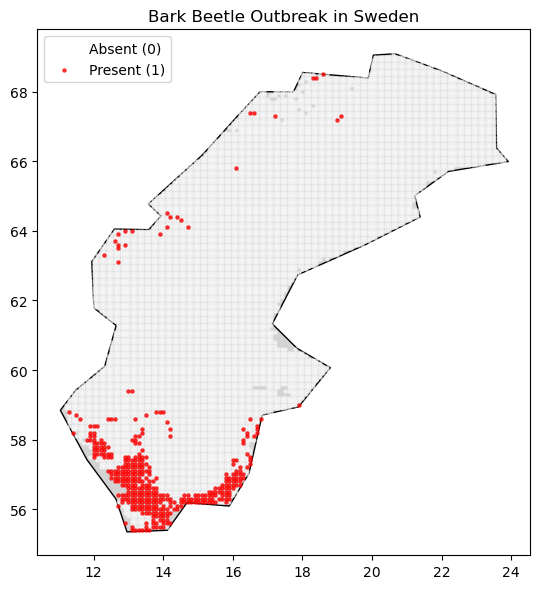

: 

: 

In [ ]:
gdf = geopandas.GeoDataFrame(
    dataset, geometry=geopandas.points_from_xy(dataset.Lon, dataset.Lat)
    )

world = geopandas.read_file('../data/country/ne_110m_admin_0_sovereignty.shp')

# Plot Sweden with t2m as a heatmap
ax = world[world['NAME'] == 'Sweden'].plot(
    color='lightgrey', edgecolor='black', figsize=(8, 6))

# Plot presence and absence with different colors
gdf_absent = gdf[gdf['Pressence_pred'] == 0]
gdf_present = gdf[gdf['Pressence_pred'] == 1]

gdf_absent.plot(ax=ax, color='white', edgecolor='white', markersize=5, alpha=0.5, label='Absent (0)')
gdf_present.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Present (1)')

ax.set_title('Bark Beetle Outbreak in Sweden')
ax.legend()
plt.tight_layout()
plt.show()